# Ideal Parameter Analysis ($\delta=2.25$, $\tau=1.25$, $\alpha=2.15$) ($\alpha$ high)

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [3]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [4]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=1.25
expected_alpha=2.15

## Initialize constants for simulation

In [5]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

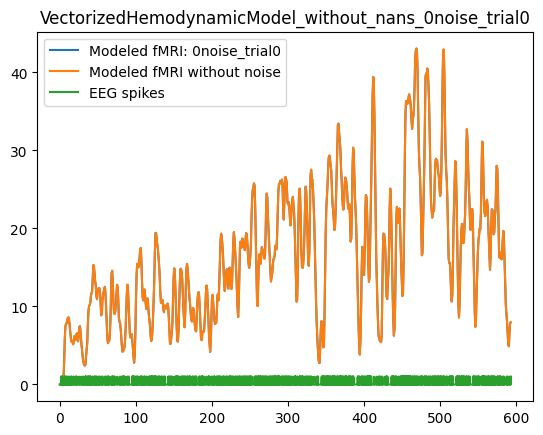

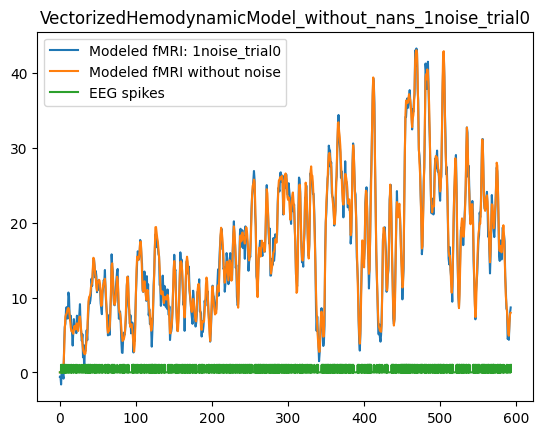

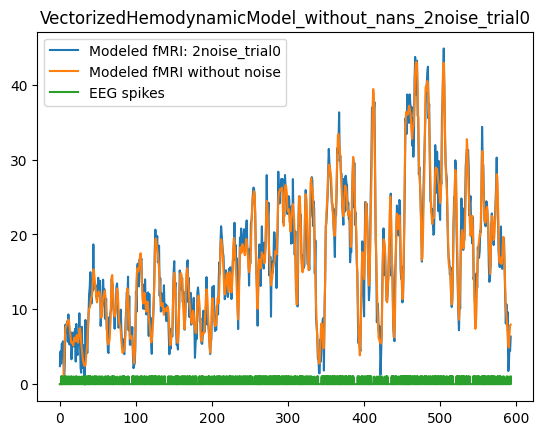

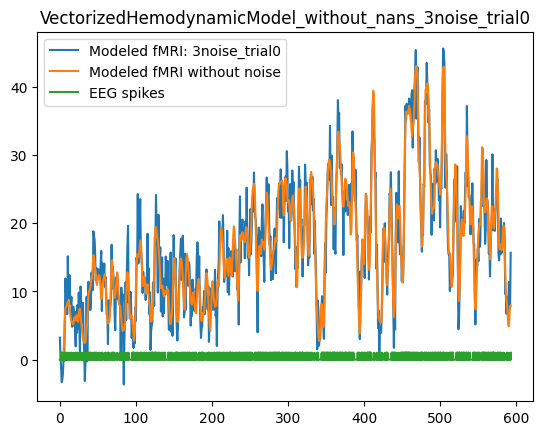

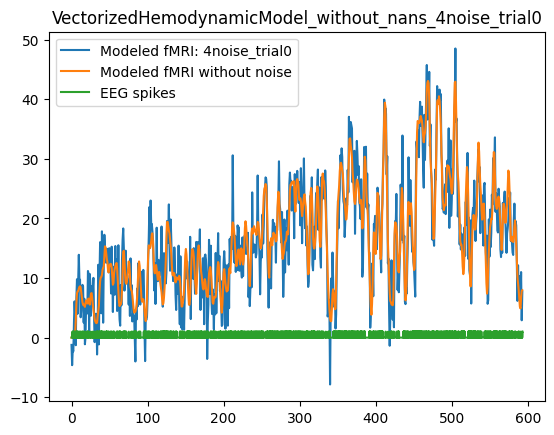

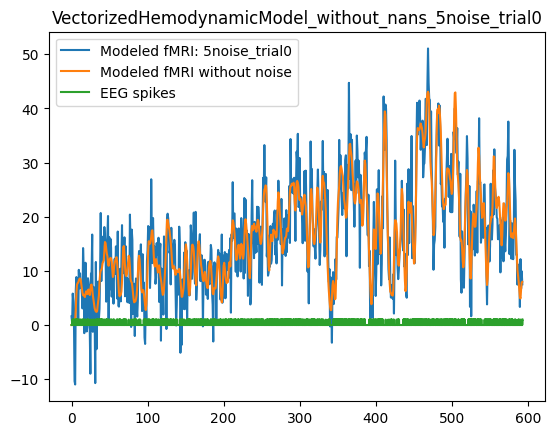

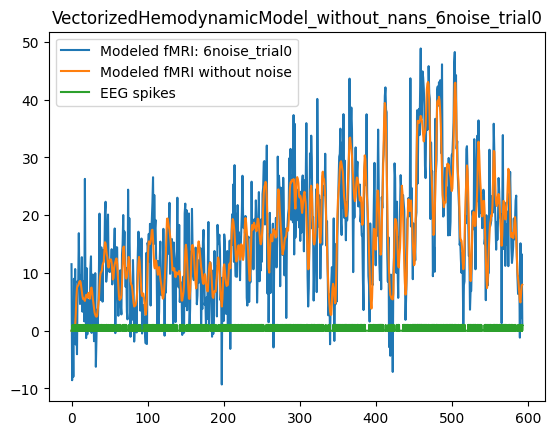

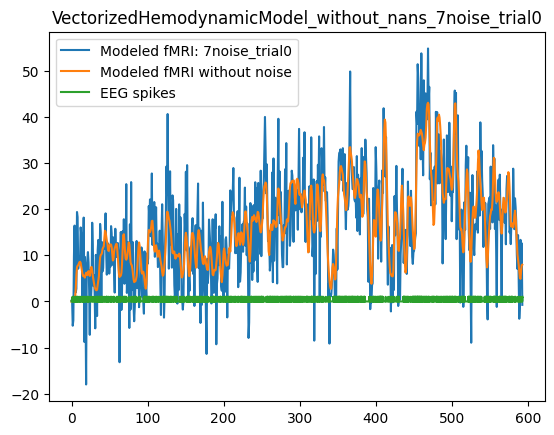

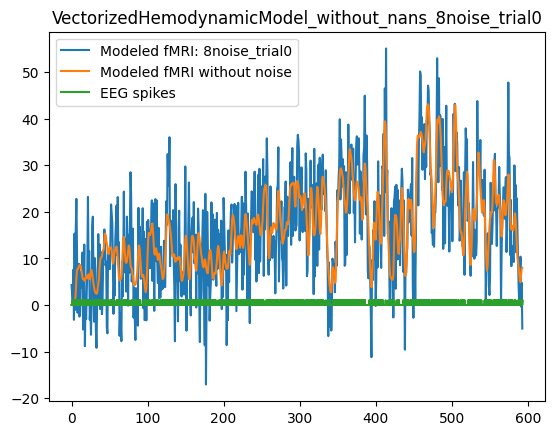

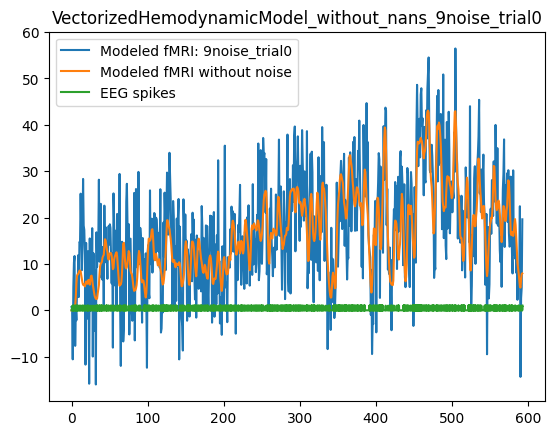

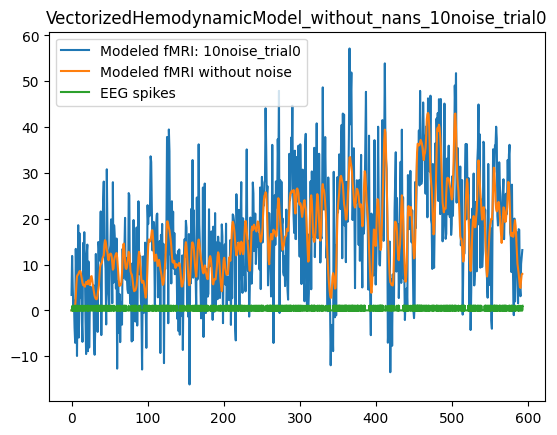

In [6]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [7]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2.15, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.25, alpha=2.15


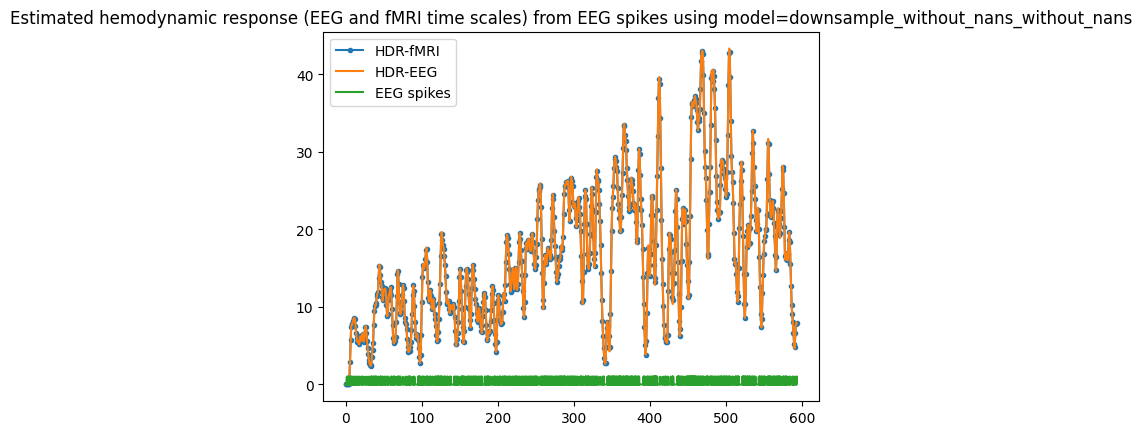

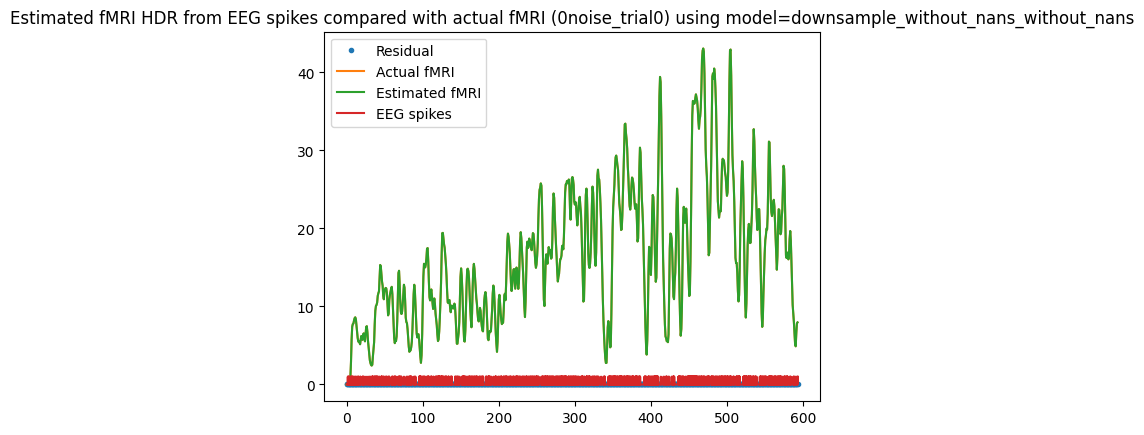

Residual Variance is 0.000000


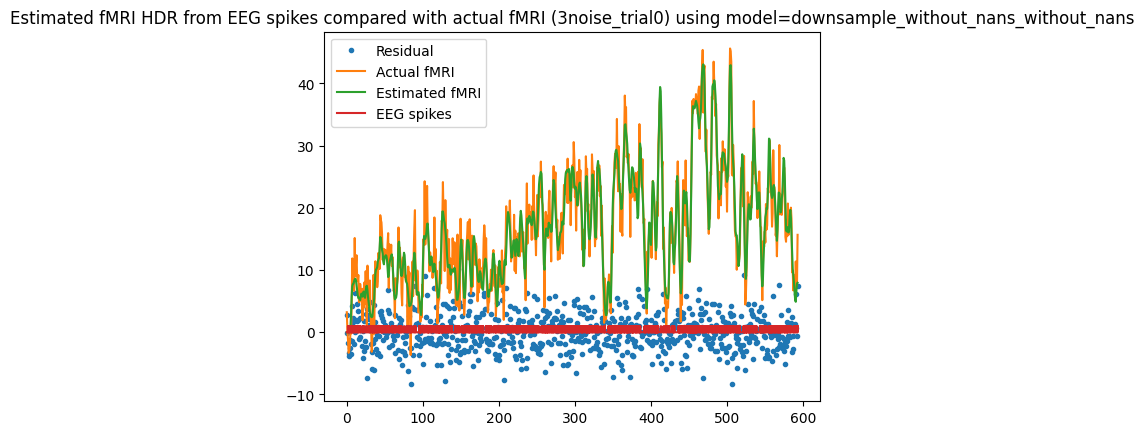

Residual Variance is 8.675641


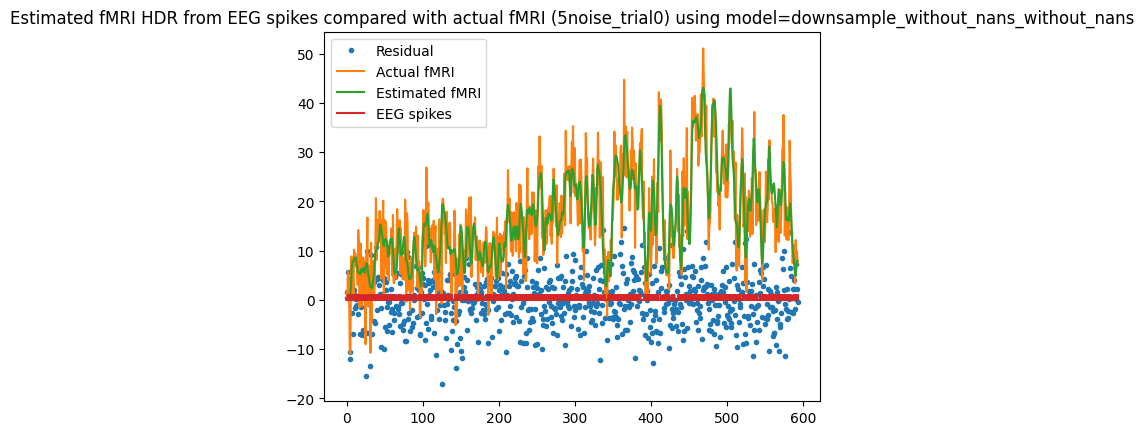

Residual Variance is 24.816109


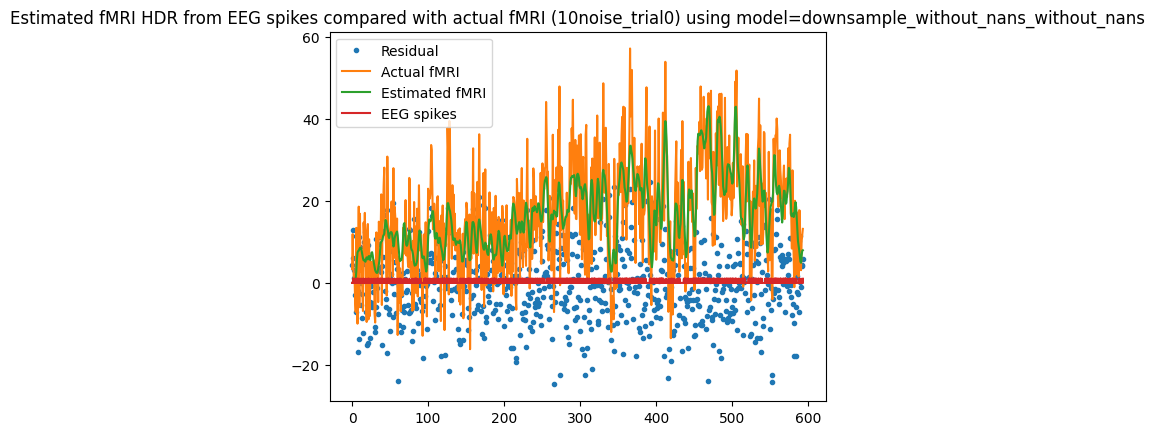

Residual Variance is 85.772524


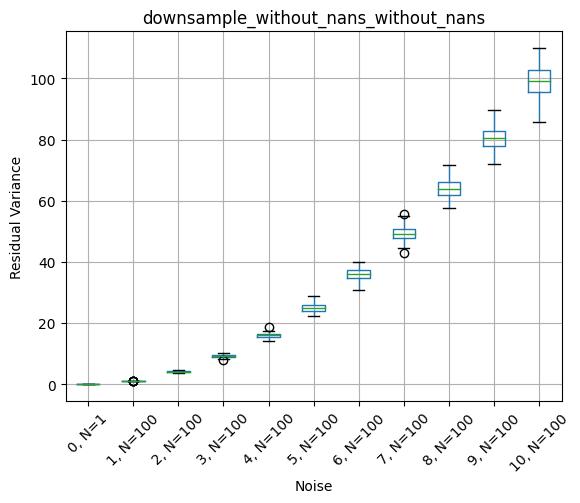

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.25, alpha=2.15


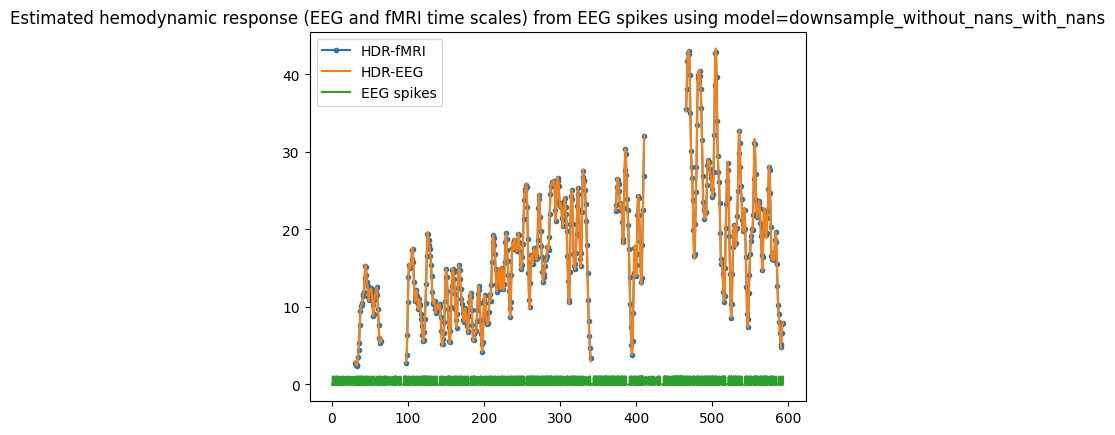

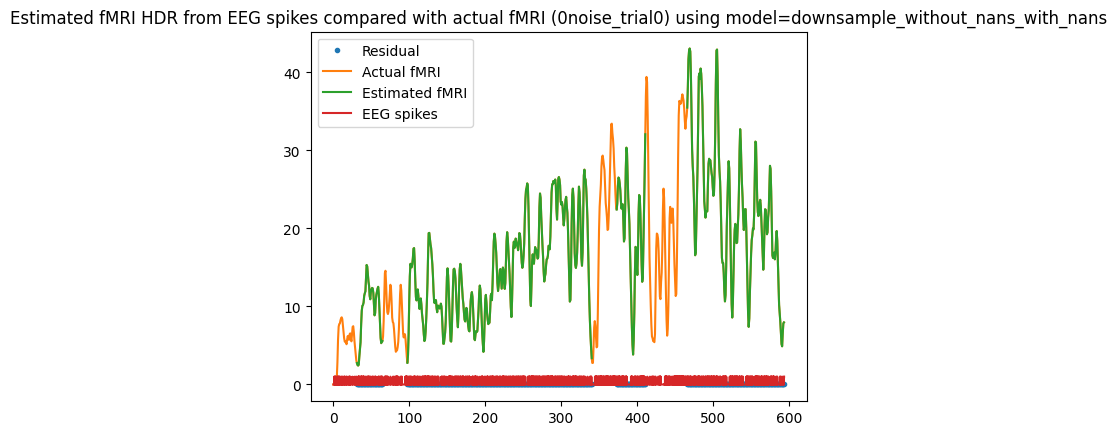

Residual Variance is 0.000000


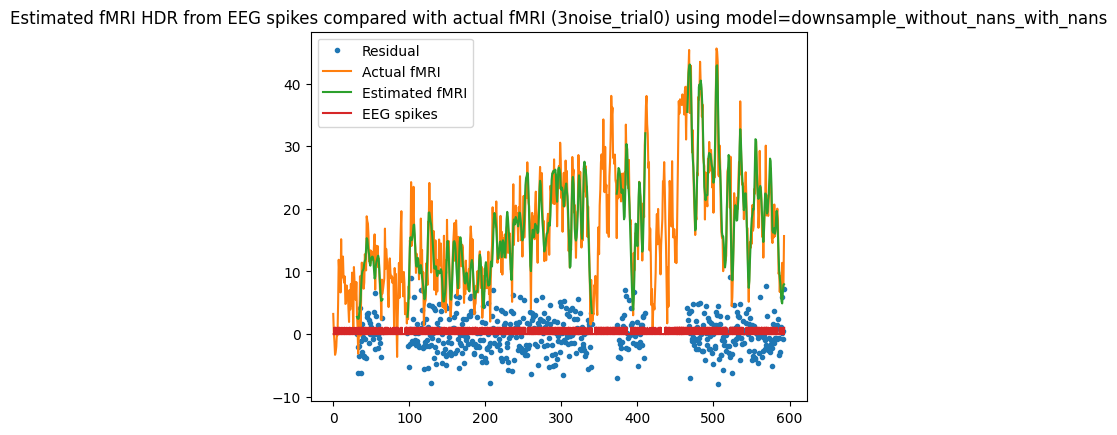

Residual Variance is 8.662350


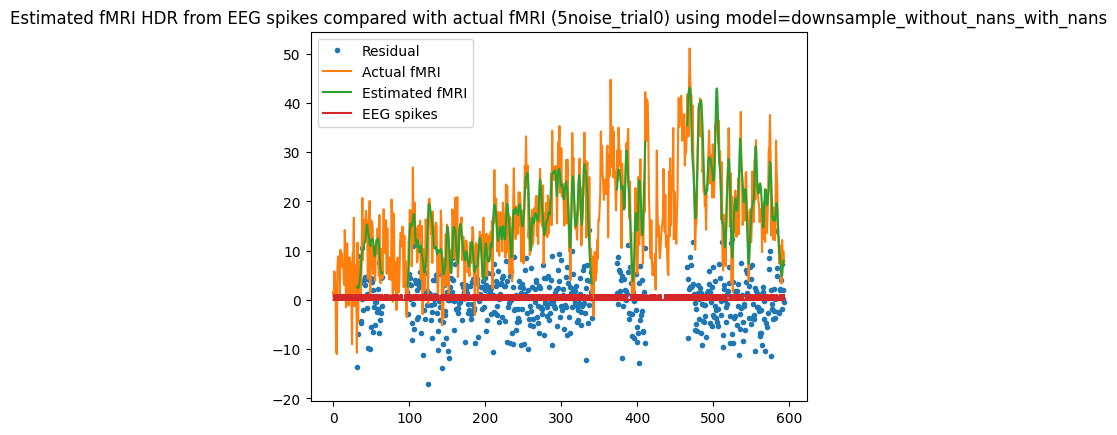

Residual Variance is 24.416523


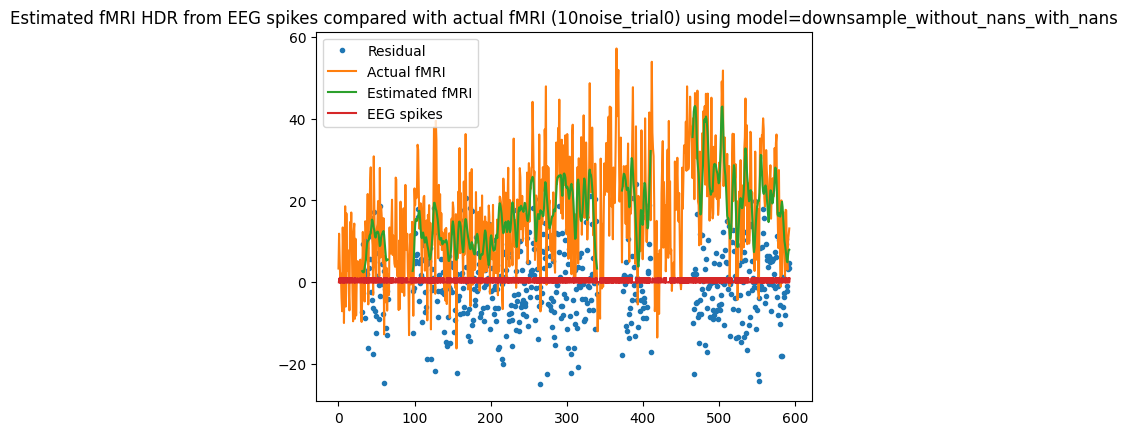

Residual Variance is 86.657333


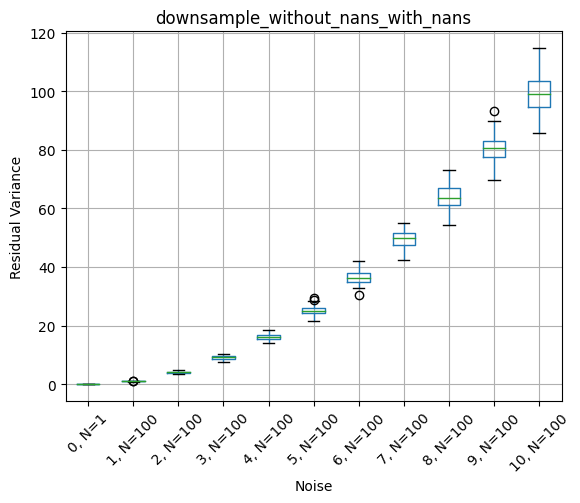

In [8]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [9]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [10]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   47.20183141519838   
1         downsample_without_nans_with_nans   42.83519310635692   
2      downsample_without_nans_without_nans  46.361592695284514   
3         downsample_without_nans_with_nans   42.12562341763083   
4      downsample_without_nans_without_nans  45.511289477553774   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  12.185643766018327   
18938  downsample_without_nans_without_nans  14.162497771911202   
18939     downsample_without_nans_with_nans  12.893063584849111   
18940  downsample_without_nans_without_nans  14.962100462079599   
18941     downsample_without_nans_with_nans  13.597898107389092   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0      47.763087341825404   49.18122309405936    53.7012883379518   
1       42.80073142742015    45.1298046831241   48.22559033247001   
2       46.92928127130364    48.3414228397474   52.89075116469996   
3      42.103525043686716   44.39953189354674  47.552568081769515   
4        46.0853598461894   47.49278922381432    52.0713080043639   
...                   ...                 ...                 ...   
18937  12.923564958767756  16.462672441903337  20.189449099643607   
18938  14.911705858087771  17.937976398201613  22.125333499203723   
18939  13.608583813089908  17.167168076439125   20.84820067467541   
18940  15.698019759221891  18.718368886596146   22.89330423672504   
18941   14.29094603781401   17.86812731005812  21.503818739067153   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0      61.216333659221334    71.6949941856082  ...   48.31504101041181   
1       55.36490337800987    66.7243545696097  ...    44.4542036407026   
2      60.408287126947975   70.88752101643573  ...   47.46959101866975   
3       54.70576984769529   66.03446532593692  ...   43.73280060738689   
4       59.59134346551826   70.07004107016306  ...   46.61405542915024   
...                   ...                 ...  ...                 ...   
18937  25.308062854645193   35.56384980606575  ...  13.170286137861668   
18938  27.599519919045658  37.378126323635556  ...  15.347830285862527   
18939  25.976601574107104    36.2365440058574  ...  13.885828301874808   
18940   28.37568219259109   38.13542074515779  ...  16.153508377367633   
18941  26.644189798670645  36.906126551127706  ...  14.599218109567552   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0      52.289291082671156  53.516905633825296   67.40116961361005   
1      47.415901141663056   49.64967586346368   62.42477869425073   
2       51.43116062615547   52.70434582511709   66.48436504992684   
3       46.69801397131312   48.96047253734549  61.670303657847676   
4       50.56286204299954  51.883848485355976   65.55641360403874   
...                   ...                 ...                 ...   
18937   16.20596578944608  21.838452318622195  31.500032017596993   
18938  18.136442367089142  23.187488120019086   34.44338638521097   
18939  16.914918649716018  22.523169964625136  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 2.5012997982022727e-28; at
       delta   tau  alpha
11786   2.25  1.25   2.15


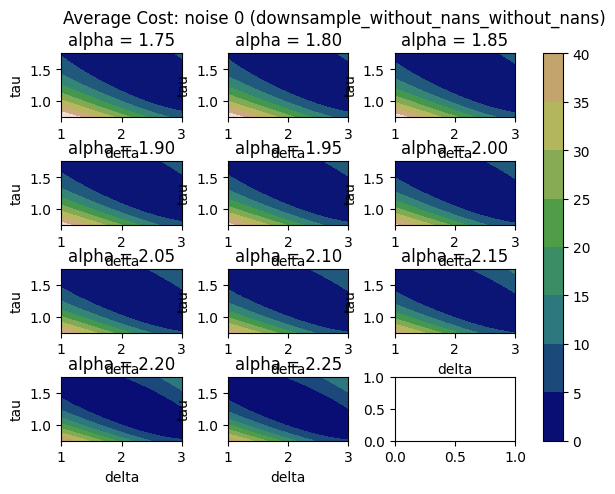

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              47.201831             
2                                              46.361593             
4                                              45.511289             
6                                              44.651523             
8                                              43.782923             
...                                                  ...             
18932                                          11.771300             
18934                                          12.565462             
18936                                          13.363093             
18938                                          14.162498             
18940                                          14.962100             

[9471 rows x 4 columns]

In [11]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [12]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2.15


delta   tau  alpha
0   2.25  1.25   2.15

### Local Minima Analysis

In [13]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2.15


noise iteration          cost  delta   tau  alpha
0      0         0  2.501300e-28   2.25  1.25   2.15
1      0         0  4.143980e-03   2.30  1.30   2.00
2      0         0  8.464244e-03   2.40  1.35   1.85

In [14]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [15]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [20]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 2.976434248652724e-28; at
       delta   tau  alpha
11787   2.25  1.25   2.15


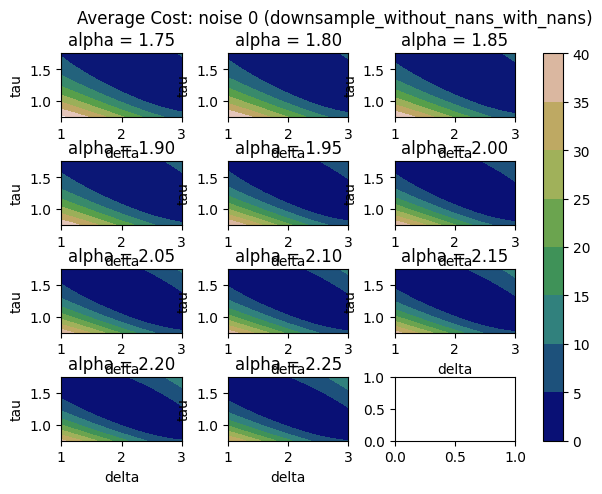

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              42.835193          
3                                              42.125623          
5                                              41.404644          
7                                              40.672716          
9                                              39.930339          
...                                                  ...          
18933                                          10.768980          
18935                                          11.477091          
18937                                          12.185644          
18939                                          12.893064          
18941                                          13.597898          

[9471 rows x 4 columns]

In [21]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [22]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2.15


delta   tau  alpha
0   2.25  1.25   2.15

### Local Minima Analysis

In [23]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2.15


noise iteration          cost  delta   tau  alpha
0      0         0  2.976434e-28   2.25  1.25   2.15
1      0         0  4.104563e-03   2.30  1.30   2.00
2      0         0  8.129314e-03   2.40  1.35   1.85

In [24]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [25]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [30]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.0007366487900797; at
       delta   tau  alpha
11786   2.25  1.25   2.15


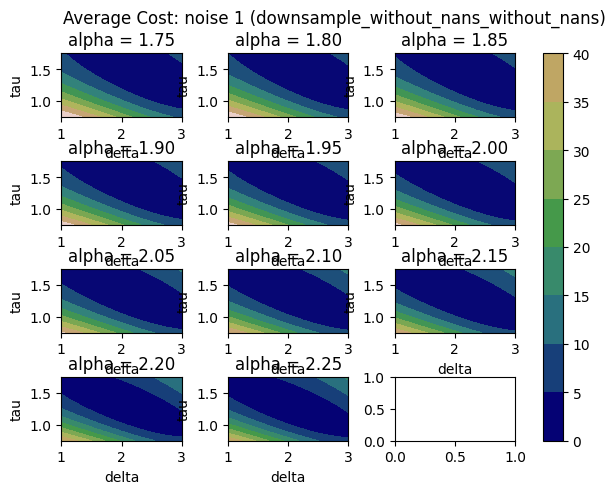

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.032354402402932; at
       delta   tau  alpha
11786   2.25  1.25   2.15


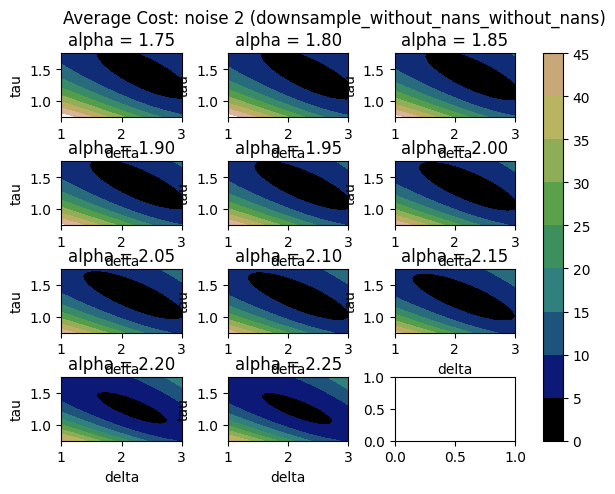

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.084009515121082; at
       delta   tau  alpha
11786   2.25  1.25   2.15


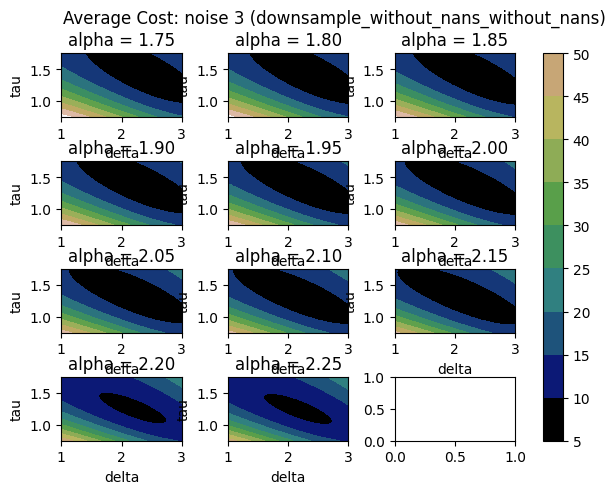

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.941409551967508; at
       delta   tau  alpha
11786   2.25  1.25   2.15


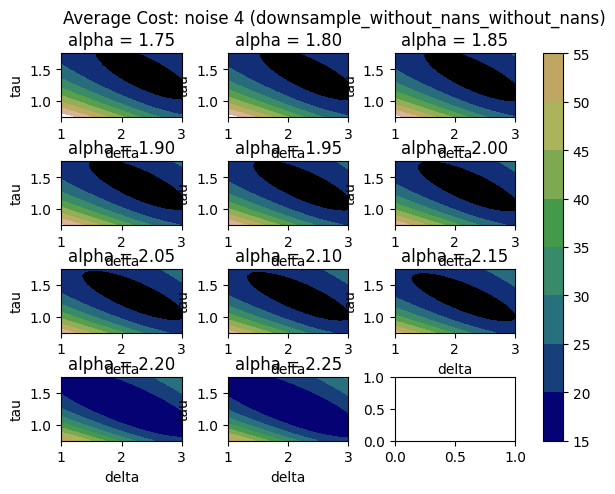

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.958061244712944; at
       delta   tau  alpha
11786   2.25  1.25   2.15


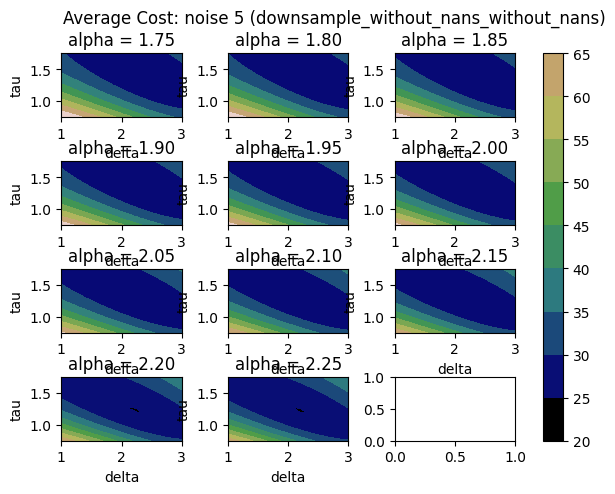

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.17151409532084; at
       delta   tau  alpha
11786   2.25  1.25   2.15


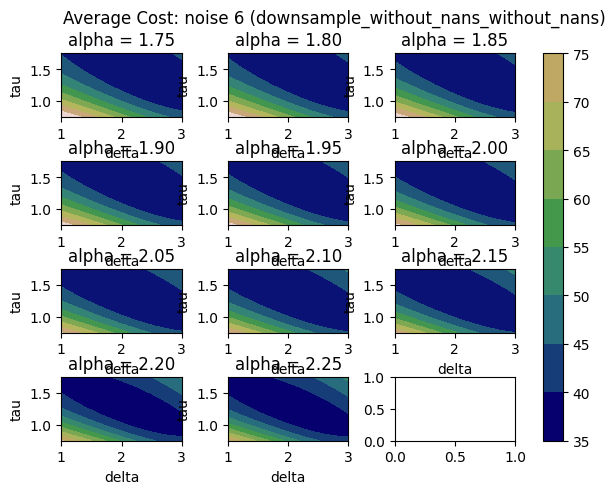

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.37332917078522; at
       delta   tau  alpha
11786   2.25  1.25   2.15


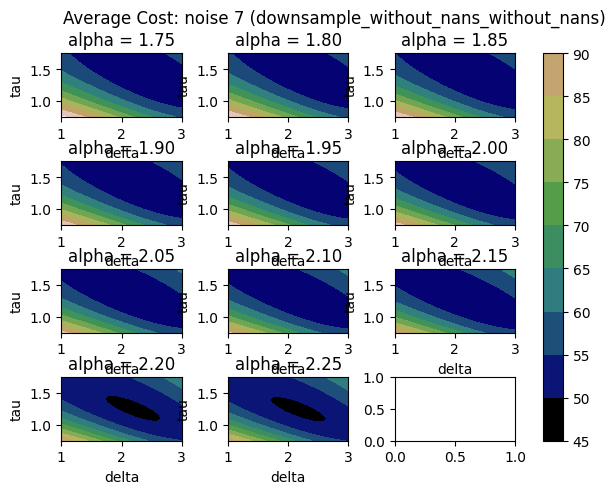

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.85963767300388; at
       delta   tau  alpha
11326    2.2  1.25    2.2


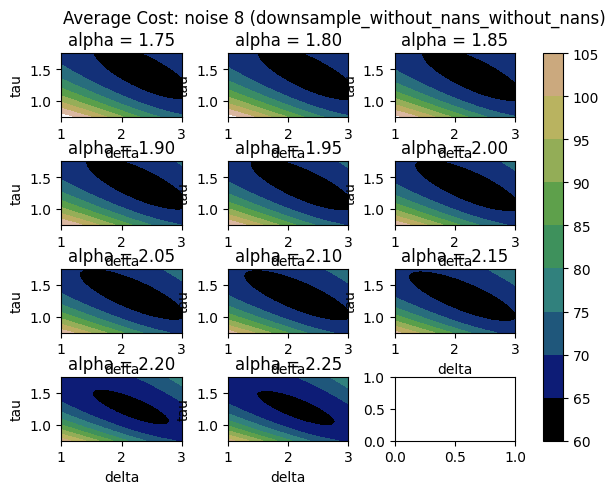

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.53937531418809; at
       delta   tau  alpha
11786   2.25  1.25   2.15


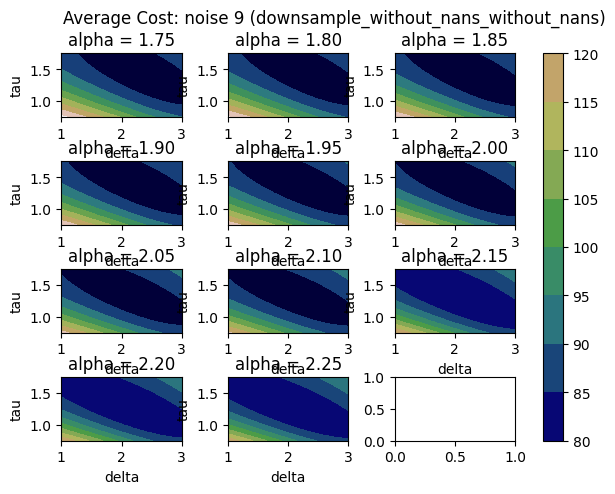

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.3364693431483; at
       delta   tau  alpha
11786   2.25  1.25   2.15


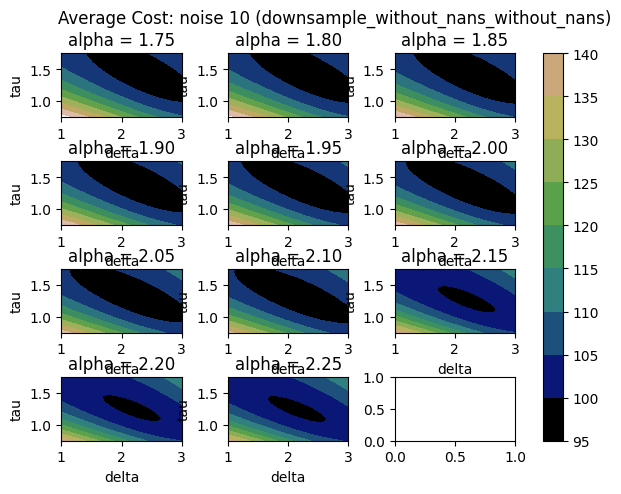

In [31]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

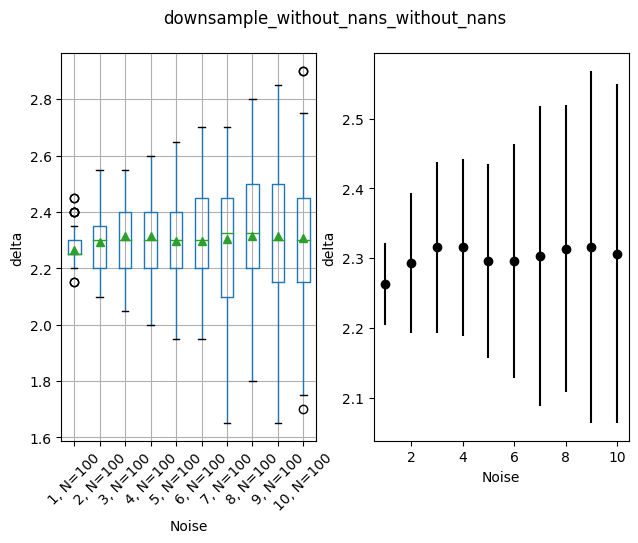

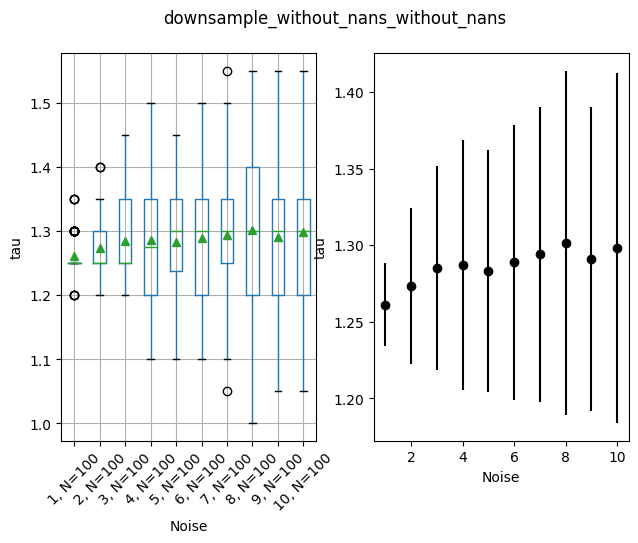

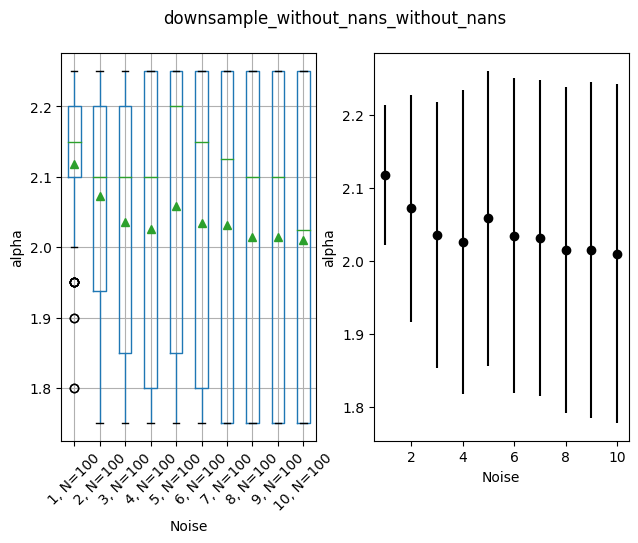

In [32]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.0000005765253277; at
       delta   tau  alpha
11787   2.25  1.25   2.15


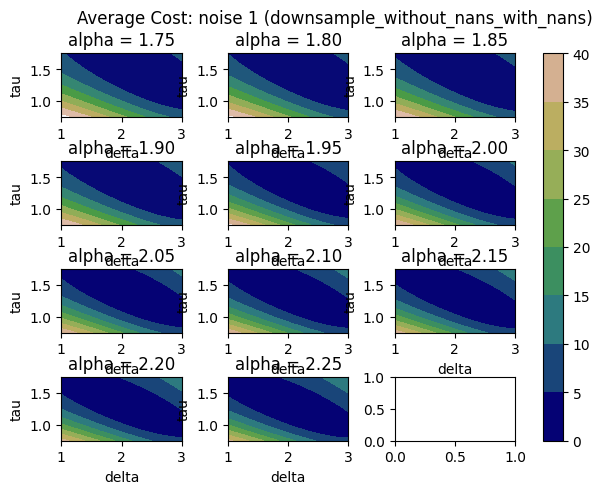

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.040102285315534; at
       delta   tau  alpha
11787   2.25  1.25   2.15


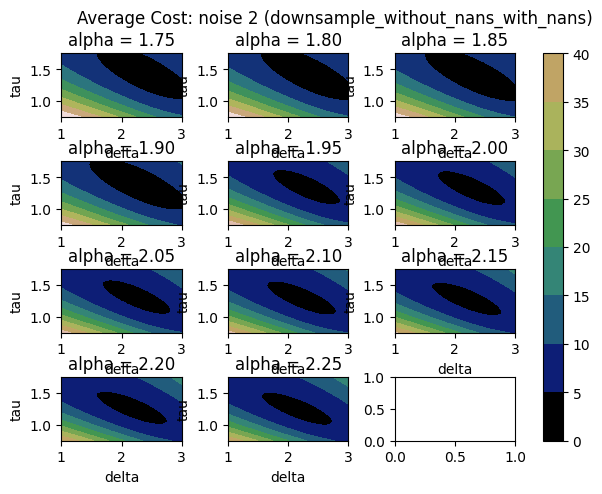

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.119388118056746; at
       delta   tau  alpha
11787   2.25  1.25   2.15


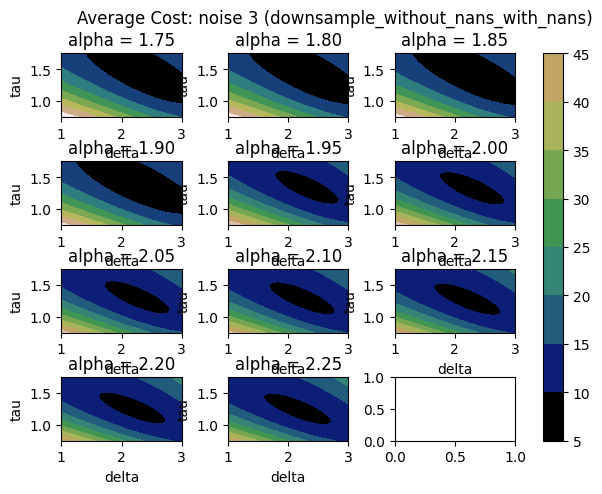

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.006345664546394; at
       delta   tau  alpha
12247    2.3  1.25    2.1


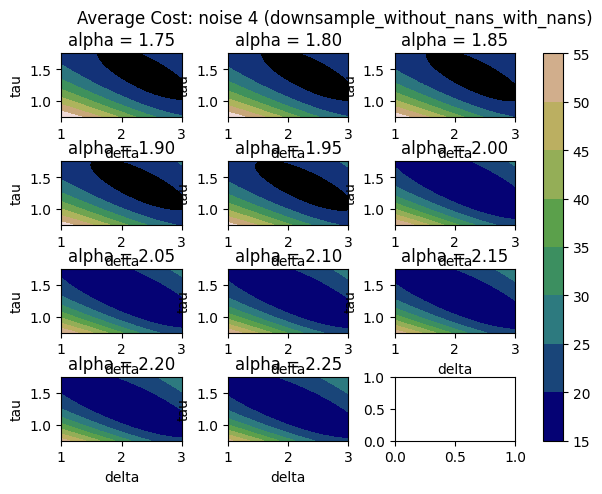

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.054599045098072; at
       delta   tau  alpha
11787   2.25  1.25   2.15


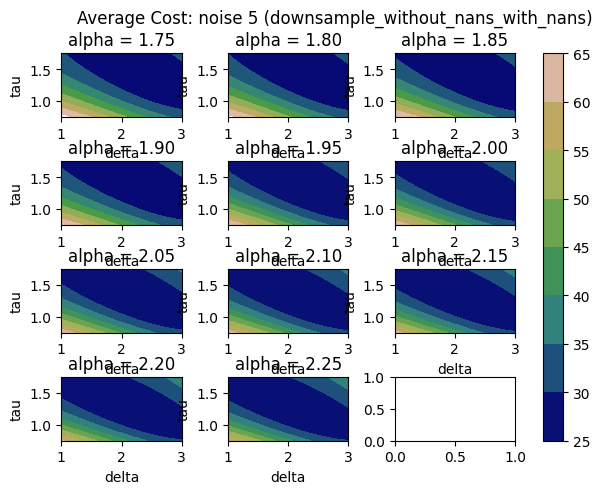

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.42309080579137; at
       delta  tau  alpha
12265    2.3  1.3    2.0


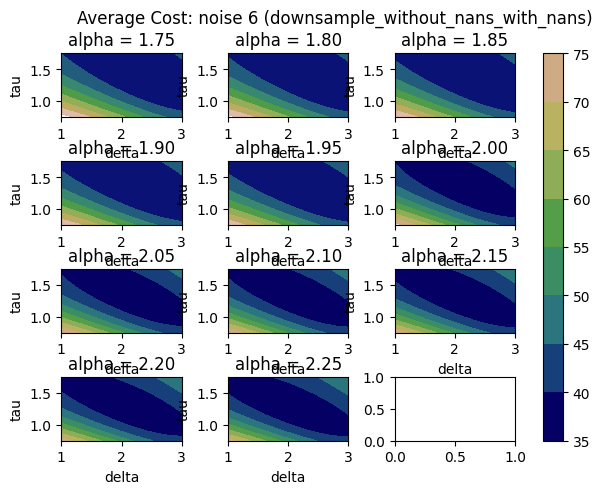

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 49.47142069736597; at
       delta   tau  alpha
11787   2.25  1.25   2.15


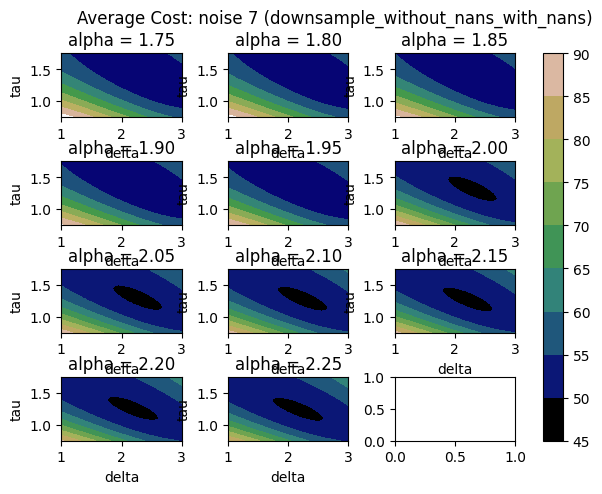

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.9435242720311; at
       delta   tau  alpha
11787   2.25  1.25   2.15


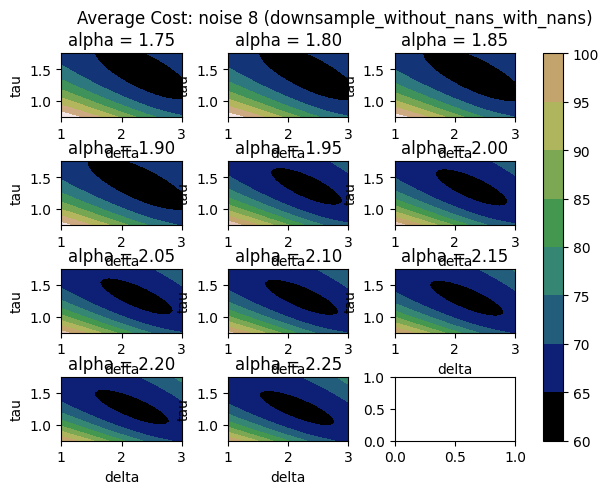

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.27086355805173; at
       delta  tau  alpha
12265    2.3  1.3    2.0


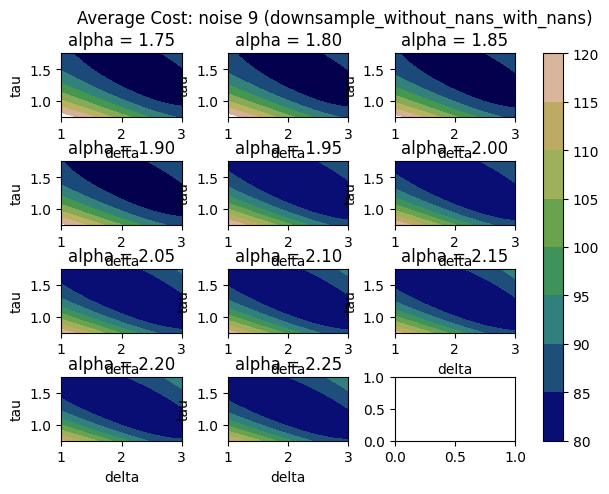

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.0233767094266; at
       delta   tau  alpha
11787   2.25  1.25   2.15


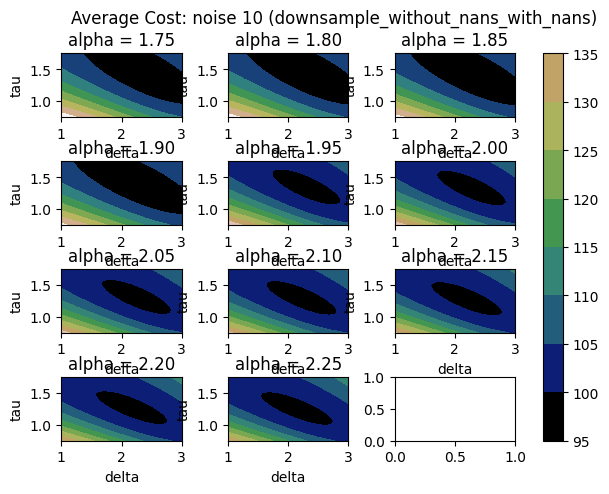

In [33]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


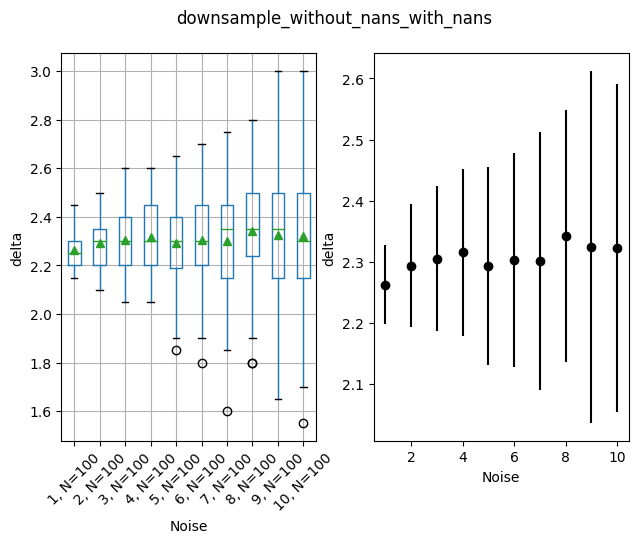

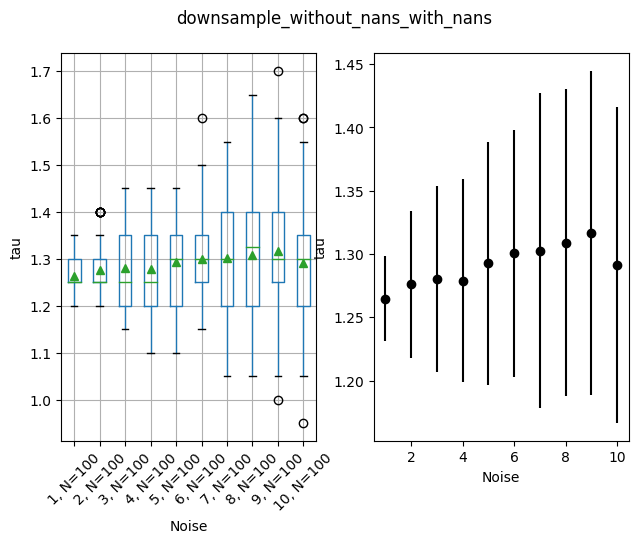

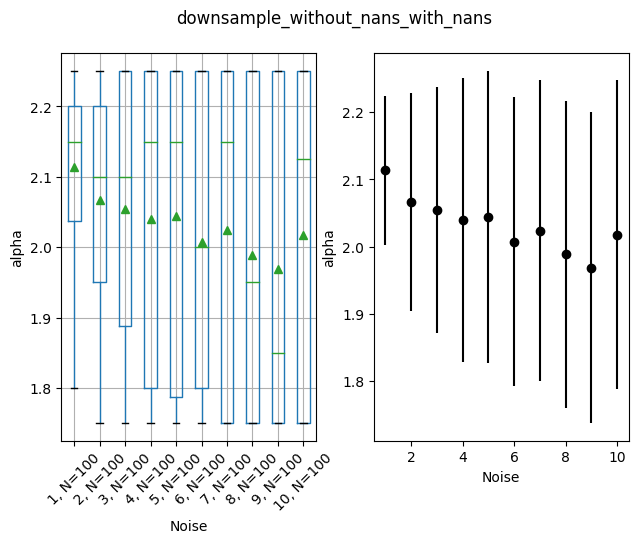

In [34]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [35]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [36]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [37]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        91    0.980479  2.1500000000000012  1.2500000000000004   
1         1        85    1.076198  2.1500000000000012  1.2500000000000004   
2         1        53    0.982589   2.200000000000001  1.2000000000000004   
3         1        54    1.077203   2.200000000000001  1.2000000000000004   
4         1        43    0.999693   2.200000000000001  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
2648     10        54   98.919398  2.7500000000000018  1.3000000000000005   
2649     10        19  103.790730  2.7500000000000018  1.3500000000000005   
2650     10         5   99.778431  2.8000000000000016  1.1500000000000004   
2651     10         9   98.602573  2.9000000000000017  1.2000000000000004   
2652     10        99  103.719786  2.9000000000000017  1.2000000000000004   

                   alpha  
0                    2.2  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.1500000000000004  
...                  ...  
2648                1.75  
2649                1.75  
2650                1.85  
2651                1.75  
2652                1.75  

[2653 rows x 6 columns]

In [38]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min  25%  50%   75%  max
noise                                                                 
1                      100.0  3.18  0.592546  2.0  3.0  3.0  4.00  4.0
2                      100.0  3.48  0.658741  1.0  3.0  4.0  4.00  4.0
3                      100.0  3.17  0.817177  1.0  3.0  3.0  4.00  4.0
4                      100.0  2.82  1.085999  1.0  2.0  3.0  4.00  4.0
5                      100.0  2.61  1.136137  1.0  2.0  3.0  3.25  5.0
6                      100.0  2.53  1.158674  1.0  1.0  3.0  3.00  5.0
7                      100.0  2.50  1.218544  1.0  1.0  3.0  3.25  5.0
8                      100.0  2.27  1.196417  1.0  1.0  2.0  3.00  6.0
9                      100.0  2.04  1.081712  1.0  1.0  2.0  3.00  5.0
10                     100.0  1.93  1.027451  1.0  1.0  2.0  3.00  4.0

#### Local minima at edges

In [39]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [43]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
288       1         0    1.000485  2.4000000000000012  1.4000000000000006   
289       1        22    0.998795  2.4000000000000012  1.4000000000000006   
290       1        56    0.995706  2.4000000000000012  1.4000000000000006   
291       1        59    1.006715  2.4000000000000012  1.4000000000000006   
292       1        87    1.012774  2.4000000000000012  1.4000000000000006   
...     ...       ...         ...                 ...                 ...   
2647     10        17  106.890359  2.7500000000000018  1.3000000000000005   
2648     10        54   98.919398  2.7500000000000018  1.3000000000000005   
2649     10        19  103.790730  2.7500000000000018  1.3500000000000005   
2651     10         9   98.602573  2.9000000000000017  1.2000000000000004   
2652     10        99  103.719786  2.9000000000000017  1.2000000000000004   

     alpha  
288   1.75  
289   1.75  
290   1.75  
291   1.75  
292   1.75  
...    ...  
2647  1.75  
2648  1.75  
2649  1.75  
2651  1.75  
2652  1.75  

[311 rows x 6 columns]

In [44]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        12      3   2.450000000000001    6    12      2  1.4000000000000006   
10       41     13  2.1500000000000012    5    41      8  1.3500000000000005   
2        32      5  2.4000000000000012   11    32      3  1.4000000000000006   
3        26      6   2.450000000000001    9    26      4  1.4000000000000006   
4        33      7  2.4000000000000012   11    33      5  1.4000000000000006   
5        24      6   2.450000000000001    9    24      4  1.4000000000000006   
6        27      9  2.5000000000000013    7    27      6  1.3500000000000005   
7        35      9  2.4000000000000012    7    35      7  1.3500000000000005   
8        40     12  2.5000000000000013    8    40      7  1.3500000000000005   
9        41     14  2.5500000000000016    6    41      9  1.4000000000000006   

            
      freq  
noise       
1       11  
10      10  
2       20  
3       16  
4       15  
5       16  
6       10  
7       10  
8       11  
9       11

In [45]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
1         1        85    1.076198  2.1500000000000012  1.2500000000000004   
2         1        53    0.982589   2.200000000000001  1.2000000000000004   
3         1        54    1.077203   2.200000000000001  1.2000000000000004   
29        1         2    0.927881   2.250000000000001  1.2000000000000004   
30        1        10    0.935300   2.250000000000001  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2614     10        13   92.004079  2.5000000000000013  1.1000000000000003   
2616     10        82  106.254096  2.5000000000000013  1.1500000000000004   
2619     10        88  107.578534  2.5000000000000013  1.2500000000000004   
2624     10         9   98.626805  2.5500000000000016  1.1000000000000003   
2632     10        38   99.729978  2.6000000000000014  1.0500000000000003   

                   alpha  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
29    2.2500000000000004  
30    2.2500000000000004  
...                  ...  
2614  2.2500000000000004  
2616  2.2500000000000004  
2619  2.2500000000000004  
2624  2.2500000000000004  
2632  2.2500000000000004  

[474 rows x 6 columns]

In [46]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        19      3   2.250000000000001   16    19      2  1.2000000000000004   
10       58     17   2.250000000000001    7    58      9  1.2500000000000004   
2        48      5   2.250000000000001   23    48      2  1.2000000000000004   
3        50      7   2.200000000000001   12    50      3  1.2000000000000004   
4        47      8   2.250000000000001   14    47      4  1.2000000000000004   
5        47     10   2.200000000000001   12    47      5  1.2000000000000004   
6        50     10   2.200000000000001   10    50      6  1.2000000000000004   
7        56     17  2.1500000000000012    7    56      9  1.2500000000000004   
8        48     15  2.0500000000000007    7    48      9  1.2000000000000004   
9        51     17  1.9000000000000008    5    51      8  1.2000000000000004   

            
      freq  
noise       
1       18  
10      13  
2       33  
3       29  
4       26  
5       17  
6       18  
7       14  
8       12  
9       15

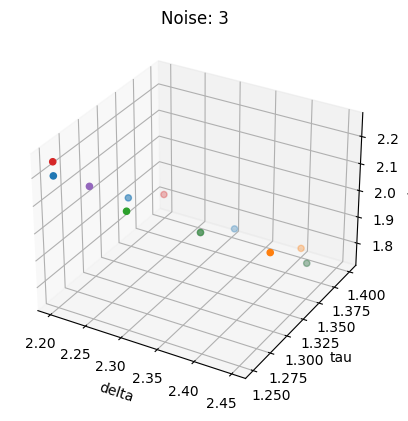

In [47]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

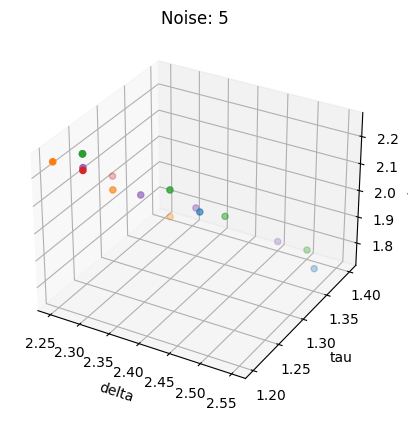

In [48]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

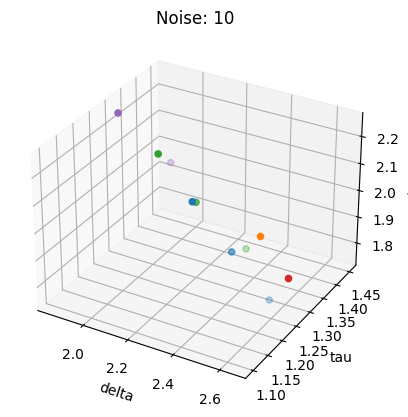

In [49]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [50]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [51]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [52]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        91    0.967710  2.1500000000000012  1.2500000000000004   
1         1         4    0.956560  2.1500000000000012  1.2500000000000004   
2         1         6    1.010746  2.1500000000000012  1.2500000000000004   
3         1        22    0.963571  2.1500000000000012  1.2500000000000004   
4         1        34    1.135928  2.1500000000000012  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
2504     10        49   95.845879  2.8500000000000014  1.2000000000000004   
2505     10        17  108.947256  2.8500000000000014  1.2500000000000004   
2506     10         9   94.676179  2.8500000000000014  1.3000000000000005   
2507     10        77   97.252966   2.950000000000002  1.2000000000000004   
2508     10        71  104.402854  3.0000000000000018  1.3000000000000005   

                   alpha  
0                    2.2  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2504                1.75  
2505                1.75  
2506                1.75  
2507                 1.8  
2508                1.75  

[2509 rows x 6 columns]

In [53]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min   25%  50%  75%  max
noise                                                                 
1                      100.0  3.19  0.662029  1.0  3.00  3.0  4.0  4.0
2                      100.0  3.25  0.715979  1.0  3.00  3.0  4.0  4.0
3                      100.0  3.01  0.937383  1.0  2.75  3.0  4.0  4.0
4                      100.0  2.76  1.129226  1.0  2.00  3.0  4.0  5.0
5                      100.0  2.26  1.194432  1.0  1.00  2.0  3.0  4.0
6                      100.0  2.42  1.138668  1.0  1.00  2.0  3.0  5.0
7                      100.0  2.06  1.032991  1.0  1.00  2.0  3.0  4.0
8                      100.0  2.20  1.119163  1.0  1.00  2.0  3.0  4.0
9                      100.0  1.95  1.122542  1.0  1.00  2.0  3.0  5.0
10                     100.0  1.99  1.087068  1.0  1.00  2.0  3.0  4.0

#### Local minima at edges

In [54]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta                 tau  \
2306      9        76   76.837181  3.0000000000000018  1.1000000000000003   
2307      9        45   78.108484  3.0000000000000018  1.1500000000000004   
2308      9        13   74.908976  3.0000000000000018  1.1500000000000004   
2309      9        13   74.899961  3.0000000000000018  1.2000000000000004   
2508     10        71  104.402854  3.0000000000000018  1.3000000000000005   

                   alpha  
2306  1.9000000000000001  
2307                1.75  
2308  1.9000000000000001  
2309                 1.8  
2508                1.75

In [56]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [58]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
287       1         0    1.023981  2.4000000000000012  1.4000000000000006   
288       1         3    1.073974  2.4000000000000012  1.4000000000000006   
289       1        16    1.073126  2.4000000000000012  1.4000000000000006   
290       1        33    0.972166  2.4000000000000012  1.4000000000000006   
291       1        57    1.039449  2.4000000000000012  1.4000000000000006   
...     ...       ...         ...                 ...                 ...   
2500     10        55  106.094349  2.8000000000000016  1.2500000000000004   
2504     10        49   95.845879  2.8500000000000014  1.2000000000000004   
2505     10        17  108.947256  2.8500000000000014  1.2500000000000004   
2506     10         9   94.676179  2.8500000000000014  1.3000000000000005   
2508     10        71  104.402854  3.0000000000000018  1.3000000000000005   

     alpha  
287   1.75  
288   1.75  
289   1.75  
290   1.75  
291   1.75  
...    ...  
2500  1.75  
2504  1.75  
2505  1.75  
2506  1.75  
2508  1.75  

[350 rows x 6 columns]

In [59]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        19      3  2.4000000000000012   10    19      2  1.4000000000000006   
10       47     18  2.4000000000000012    7    47      9  1.3500000000000005   
2        27      4   2.450000000000001   12    27      2  1.4000000000000006   
3        23      7  2.3500000000000014    5    23      4  1.4000000000000006   
4        38      8   2.450000000000001    8    38      5  1.4000000000000006   
5        36      9  2.4000000000000012    8    36      5  1.4000000000000006   
6        35     11  2.5000000000000013    7    35      9  1.3500000000000005   
7        31     11  2.3500000000000014    8    31      8  1.4000000000000006   
8        44     14   2.450000000000001    6    44      8  1.4000000000000006   
9        50     17   2.450000000000001    8    50     12  1.4000000000000006   

            
      freq  
noise       
1       18  
10      10  
2       19  
3       11  
4       15  
5       12  
6       13  
7        7  
8       13  
9       10

In [60]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration       cost               delta                 tau  \
1         1         4   0.956560  2.1500000000000012  1.2500000000000004   
2         1         6   1.010746  2.1500000000000012  1.2500000000000004   
3         1        22   0.963571  2.1500000000000012  1.2500000000000004   
4         1        34   1.135928  2.1500000000000012  1.2500000000000004   
5         1        80   1.011650  2.1500000000000012  1.2500000000000004   
...     ...       ...        ...                 ...                 ...   
2468     10        58  94.325822  2.5000000000000013  1.1500000000000004   
2469     10        61  95.932012  2.5000000000000013  1.1500000000000004   
2476     10        21  95.219883  2.5500000000000016  1.1000000000000003   
2494     10        38  98.262295  2.7500000000000018  1.0000000000000002   
2501     10        38  98.254391  2.8500000000000014  0.9500000000000002   

                   alpha  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
5     2.2500000000000004  
...                  ...  
2468  2.2500000000000004  
2469  2.2500000000000004  
2476  2.2500000000000004  
2494  2.2500000000000004  
2501  2.2500000000000004  

[465 rows x 6 columns]

In [61]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        27      3   2.250000000000001   18    27      2  1.2000000000000004   
10       54     19   2.100000000000001    7    54     11  1.2000000000000004   
2        38      5   2.200000000000001   12    38      2  1.2000000000000004   
3        51      9   2.250000000000001   15    51      3  1.2000000000000004   
4        44      9   2.200000000000001   12    44      5  1.2000000000000004   
5        52     13   2.300000000000001    9    52      7  1.2000000000000004   
6        43     13  2.1500000000000012    7    43      7  1.2500000000000004   
7        52     16  2.1500000000000012    9    52      9  1.2000000000000004   
8        53     16  2.1500000000000012   10    53     10  1.2500000000000004   
9        51     19  2.1500000000000012    6    51     11  1.2000000000000004   

            
      freq  
noise       
1       20  
10      14  
2       23  
3       31  
4       23  
5       16  
6       13  
7       15  
8       12  
9       12

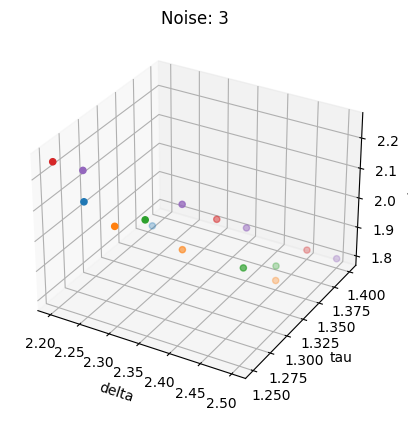

In [62]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

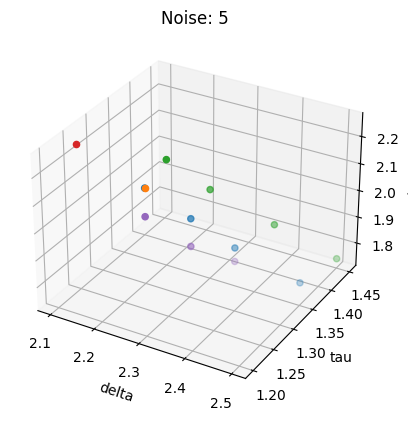

In [63]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

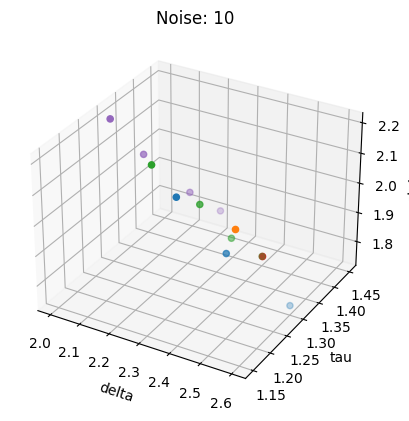

In [64]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()